# Pneumothorax Identification from X-Ray Images

By Reynaldo Vazquez<br>
April 2021<sup>1</sup>

<br>

This notebooks presents my solution to the [SIIM-ACR Pneumothorax Segmentation; Identify Pneumothorax Disease in Chest X-Rays](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation) challenge. The challenge consists on detecting pneumothorax disease (i.e. collapsed lung disease) from x-ray images and masking the location of the disease within the x-ray image. 

<h3> The solution consists on a two-step approach. </h3>

1. The first step is to run the images through an ensemble of binary image neural network classifiers to determine whether the x-ray presents pneumothorax disease. 

2. The second step, runs the image through an ensemble of segmentation neural networks to identify the location of the disease. 

This approach achieves a [Dice coefficient of 0.8522](https://www.kaggle.com/reyvaz/pneumothorax-inference-submission?scriptVersionId=59143042) in the official private test data of the competition, on par with the top 3% of the results. 

In [ ]:
#@markdown Prediction Examples
%%html
<div style = "max-width:950px" align="center">
<iframe src="https://rexvaz.com/files/pneumothorax/carousel_narrow.html" width="100%" height="255" 
frameBorder="0"></iframe>
</div>


<h2> Data </h2>

To train using TPUs, I extracted the original data from DICOM files (X-Rays, patient metadata) and CSV files (mask RLE encodings) and placed it in TFRec files. The original DICOM and CSV data can be found [here](). The TFRecs created for this notebook can be found [here](https://www.kaggle.com/reyvaz/siimacr-pneumothorax-segmentation-tfrecs). Note that I changed the type of RLE encoding from relative to absolute initial pixel values, more on this can be found the TFRec dataset description.

<br>
<h2> Training and Evaluation </h2>

All 1st and 2nd step neural networks were trained on a K = 5, K-Fold cross-validation distribution of the data and on different image sizes. Random data augmentations were applied to training partition data for all networks in both stages. Data augmentation was also applied to evaluation data (i.e. out-of-fold and test data) for the 1st step.  

<h3> Binary Classification </h3>

The ensemble for the binary classification step consists of EfficientNet (Tan & Le 2020) based classifiers versions B1-B4. The classifiers were selected according to their out-of-fold performance. The metric optmized for this task was accuracy on the full validation partition for each fold, although AUC, sensitivity, and specifity were also monitored and reported. 

Although there’s no official labeled test set for this task, out-of-fold accuracy was >  0.92 across folds. Adjustment of the classification thresholds could achieve >  0.99 accuracy, (sensitivity ~ 0.95 and specificity > 0.99) while rendering about a fourth of the results inconclusive. 

<h3> Pnneumothorax Segmentation </h3>

The ensemble for the 2nd step consists of U-Net (Ronneberger et al., 2015) and UNet++ (Zhou et al., 2019) based CNNs, all with EfficientNet encoders versions B0-B4. The networks included in the ensemble were selected according to their out-of-fold performance on X-Rays with the disease. The metric used for this task was the Dice Coefficient. Although batch-wise average Dice coefficient calculations were monitored and used in backpropagation as part of the loss, it was image-wise average Dice coefficient performance what was considered for model selection. Both calculations vary widely, but the latter showed to be more stable and consistent when comparing across different specifications. 

The formula to calculate the Dice Coefficient is given by: 

$$
\begin{align*}
\text{Dice Coefficient} = \frac{2|\hat{Y} \cap Y|}{|\hat{Y}| + |Y|}
\end{align*}
$$

where $\hat{Y}$ is the predicted set of pixels and $Y$ is the ground truth.

<br>
<h2> Acknowledgements: <h2>

Thanks to [The Society for Imaging Informatics in Medicine (SIIM)](https://siim.org/) and the [American College of Radiology (ACR)](https://www.acr.org/) for creating and providing the dataset.

<br>
<h2> Running this notebook: </h2>

1. (Required) re-running this notebook requires that the GCS path to the TFRecs be updated. To do so, follow the instructions in this [link]( https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path) and paste the valid GCS path into the `GCS_PATH` variable below. 

2. (Optional) file management can work AS IS within Colab’s virtual  environment. However, to save trained weights beyond the current session, specify a path to a connected google drive directory in the `PROJECT_DIR` variable. 

<sup>1</sup> This version April 2021, first version February 2021.









# Setup

## Mode

- `TRAINING = True` will train the binary and segmentation specifications indicated in the training section. `False` will skip training. 

- `ADD_PRETRAINED = True` will download weights trained using the pneumothorax dataset images corresponding to FOLD 1. 

- To save trained weights beyond the current session, specify a path to a connected Google Drive in `PROJECT_DIR`. 

- If the subdirectory corresponding to `weights_dir` does not exist or is empty (e.g. the first time running this notebook), at least one of `TRAINING` or `ADD_PRETRAINED` must be `True`. 

In [ ]:
TRAINING = True         #@param {type: 'boolean'}
ADD_PRETRAINED = True   #@param {type: 'boolean'}
PROJECT_DIR = './'
weights_dir = PROJECT_DIR + 'weights/'
!mkdir -p {weights_dir}

## Requirements

In [ ]:
import os, sys, math, re, gc, random
from time import time, strftime, gmtime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold

if not os.path.isdir('tpu_segmentation'):
    !git clone -q https://github.com/reyvaz/tpu_segmentation.git
    !pip install -qr tpu_segmentation/requirements.txt >/dev/null
    !wget -q https://raw.githubusercontent.com/reyvaz/pneumothorax_detection/master/pneumothorax_utils.py
from tpu_segmentation import *
from pneumothorax_utils import *

start_notebook = time()
print('Notebook started at: ', current_time_str())
print('Tensorflow version: ', tf.__version__)
tf.get_logger().setLevel('ERROR')

Notebook started at:  10:20 AM
Tensorflow version:  2.4.1


In [ ]:
#@markdown TPU Distribution Strategy
try: tpu
except:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    else:
        # Default distribution strategy. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.5.238.194:8470


<h3> GCS Path </h3>

Follow this [link](https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path) to update GCS Path if needed. 

In [ ]:
GCS_PATH = 'gs://kds-891dd2a73df9712b393ae139fbbdc34cd2837b067190170685298346'
renew_url = 'https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path'
verify_gcs_path(GCS_PATH, renew_url)

GCS path is valid


<h3> Constants and TFRecs </h3>

In [ ]:
IMAGE_SIZE = [1024, 1024] # original size of the x-ray images
N_CLASSES = 1
N_CHANNELS = 1
N_REPLICAS = strategy.num_replicas_in_sync
classes = ['No Disease', 'Disease']

TFRecs_gcs_path = GCS_PATH + '/tfrecs/'
TFRECS_TRAIN_RLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-disease*.tfrec')
TFRECS_TRAIN_NORLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-no-disease*.tfrec')

N_TFRECS_MASK = len(TFRECS_TRAIN_RLE)
N_TFRECS_NOMASK = len(TFRECS_TRAIN_NORLE)

## K-Fold File Ditribution

**K-Fold Distribution $(K=5)$**

Fold numbering has base $1$. i.e.  $k \in \{1,2,3,4,5\}$

The following allows the K-Fold data partition to return datasets with or without "unmasked" examples (i.e. examples with or without the disease). 

**For the binary model**: <br>

- Retrieve all masked and unmasked examples (i.e. select `use_unmasked = True`). The dataset pipeline has the option to undersample unmasked examples with the variable `p_undersample`. 

**For the segmentation model** <br>
- Select `use_unmasked = 'False'` to exclude all non-disease examples from training and validation. 

- For validation, during training, use a constant batch size across specifications. This will make the Dice metric more consistent and comparable because the metric is affected by batch size.

Because of the way Dice coefficient is calculated during training, examples in the last validation batch might have a disproportionate effect on the metric. 
To minimize this issue: 

- Use a repeated validation dataset with specified validation steps.  
- Use a finite validation dataset and optimize the batch size to minimize the oversized influence of images in the last batch (i.e. make sure the size of the last batch is as close as possible to batch size)
- Or drop remainder with a batch size that minimizes wasted examples (i.e. make the remainder batch as small as possible). This is the method chosen below. A batch size of `11*N_REPLICAS=88` minimizes wasted examples (typically only 8 or 4 examples are thrown out, depending on the fold). 

The above is not an issue for the binary model (i.e. accuracy), so use a finite validation dataset without batch size restrictions. 


In [ ]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(N_TFRECS_MASK))):
    folds.update({fold+1: {'val': idxV, 'train': idxT}})
del fold

def get_fold_file_lists(fold_num, folds=folds, use_unmasked = False):
    fold = folds[fold_num]
    TRAINING_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['val']]

    if use_unmasked:
        TRAINING_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['train']]
        VALIDATION_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['val']]
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

masked_examples = count_data_items(TFRECS_TRAIN_RLE)
unmasked_examples = count_data_items(TFRECS_TRAIN_NORLE)
class_ratio = unmasked_examples/masked_examples

print('Number of MASKED examples for training and validation:   ', masked_examples)
print('Number of NON MASKED examples for training and validation:', unmasked_examples)

Number of MASKED examples for training and validation:    2669
Number of NON MASKED examples for training and validation: 9378


## Dataset Pipeline

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_tfrecord(example, vars = ('image', 'rle', 'label')):
    features = {
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'image': tf.io.FixedLenFeature([], tf.string), 
        'rle': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        }
    features = {k: features[k] for k in vars}
    example = tf.io.parse_single_example(example, features)
    return [example[var] for var in features]
        
def load_dataset(filenames, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    return dataset.map(read_tfrecord, num_parallel_calls=AUTO)

In [ ]:
undersample_filter = lambda L, P: False if L == 0 and tf.random.uniform([]) < P else True
# randomly filters-out examples with label 0. L is the label, P is the rate to exclude

def decode_resize_inputs(inputs, target_size, image_size = IMAGE_SIZE,
                         n_channels = N_CHANNELS, n_classes = N_CLASSES):
    (image_data, rle), args = inputs[:2], inputs[2:]
    image = tf.image.decode_jpeg(image_data, channels=n_channels)
    image = tf.cast(image, tf.float32) / 255.0  
    mask = build_mask_array(rle, image_size)

    if target_size != image_size:
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

    image = tf.reshape(image, [*target_size, n_channels]) 
    mask = tf.reshape(mask, [*target_size, n_classes])
    return (image, mask, *args)

def data_augment(inputs, target_size, 
                 n_channels = N_CHANNELS, n_classes = N_CLASSES, 
                 p1=0.50, p2=0.33, p3=0.33, p4=0.75):
    
    (image, mask, label), args = inputs[:3], inputs[3:]

    if tf.random.uniform([]) < p1:
        image, mask = left_right_flip(image, mask)

    if tf.random.uniform([]) < p2:
        image, mask = random_rotate(image, target_size, n_channels, mask, 
                                    n_classes, 7.)
    elif tf.random.uniform([]) < p2:
        image, mask = random_shear(image, target_size, n_channels, mask)

    if tf.random.uniform([]) < p3: 
        image, mask = random_zoom_out_and_pan(image, target_size, mask, n_channels)
    elif tf.random.uniform([]) < p3*1.5: 
        image, mask = image_mask_zoom_in(image, mask, target_size, label, n_channels)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.7, 1.4)

    if tf.random.uniform([]) < p4: 
        image = coarse_dropout(image, target_size, n_channels, 
                               count_range=(20, 150), m_size = 0.01)
    return (image, mask, label, *args)

def final_reshape(inputs, target_size, target_var, make_rgb, augment,
                  n_channels = N_CHANNELS, n_classes = N_CLASSES):
    '''
    Converts image to 3 channels if specified by `make_rgb`
    Applies augmentations that require 3 channels if requested by `augment`
    Returns the image and one of {mask, label}, as specified by `target_var`
    '''
    (image, mask, label), args = inputs[:3], inputs[3:]

    if make_rgb:
        image = tf.image.grayscale_to_rgb(image)
        n_channels = 3
        if augment:
            image = tf.image.random_hue(image, 0.025)
            image = tf.image.random_saturation(image, 0.6, 1.4)

    image = tf.reshape(image, [*target_size, n_channels]) 

    if target_var == 'mask':
        mask = tf.reshape(mask, [*target_size, n_classes])
        target_var = mask
    elif target_var == 'label': target_var = tf.cast(label, tf.int32)
    else: raise Exception('target_var must be one of \'label\' or \'mask\'')
    return image, target_var

describe_ds = lambda x: print(re.sub('[<>]', '', str(x)))

def print_description(train_ds, val_ds, steps_per_epoch, use_unmasked, 
                      p_undersample, n_train, n_valid):
    describe_ds(train_ds)
    print('Steps per epoch: ', steps_per_epoch)
    approx = 'approx' if p_undersample and p_undersample !=1 and use_unmasked else ''
    print('Num train examples {} {}'.format(n_train, approx))
    print('Num valid examples {}'.format(n_valid))
    return None

In [ ]:
def get_dataset(filenames, target_size, batch_size, target_var = 'mask',
                make_rgb = True, 
                augment = False,
                cache   = False,
                repeat  = False, 
                shuffle = False,
                ordered = False, 
                drop_remainder = False,
                p_undersample = False):
    dataset = load_dataset(filenames, ordered)
    if p_undersample:
        dataset = dataset.filter(lambda *data: undersample_filter(data[2], p_undersample))
    dataset = dataset.map(lambda *data: decode_resize_inputs(data, target_size), AUTO)
    if augment:
        dataset = dataset.map(lambda *data: data_augment(data, target_size), AUTO)
    dataset = dataset.map(lambda *data: final_reshape(data, target_size, 
                                      target_var, make_rgb, augment), AUTO)
    if cache: dataset = dataset.cache()  
    if repeat: dataset = dataset.repeat() 
    if shuffle: dataset = dataset.shuffle(shuffle, reshuffle_each_iteration=True) 
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_datasets(fold_num, target_size, imgs_per_replica, target_var = 'mask',
             use_unmasked = False, p_undersample = False, cache_val = True, print_descr = True):
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(
        fold_num, use_unmasked=use_unmasked)
    
    train_batch_size = imgs_per_replica * N_REPLICAS

    n_train = count_data_items(TRAINING_FILENAMES)
    n_valid = count_data_items(VALIDATION_FILENAMES)

    if p_undersample and use_unmasked:
        # approx number of examples given random undersampling, val is never undersampled
        n_train = int(n_train * (1-(p_undersample*class_ratio)/(1+class_ratio)))

    train_steps = np.ceil(n_train/train_batch_size).astype(int)
    buffer_size = int(n_train*0.33)

    random.shuffle(TRAINING_FILENAMES)
    train_dataset = get_dataset(TRAINING_FILENAMES, target_size, train_batch_size, 
                                target_var, 
                                augment = True, 
                                repeat = True, 
                                shuffle = buffer_size,
                                drop_remainder=True, 
                                p_undersample = p_undersample)
    
    val_batch_size = 11 * N_REPLICAS # constant validation dataset for dice metric comparison
    # 11 * N_REPLICAS minimizes wasted examples in all folds due to drop_remainder. 

    val_steps = np.ceil(n_valid/val_batch_size).astype(int)
    if target_var == 'mask': val_steps -= 1 # val steps in segmentation due to drop_remainder.

    drop_remainder_val = True if target_var == 'mask' else False

    valid_dataset = get_dataset(VALIDATION_FILENAMES, target_size, val_batch_size, target_var, 
                                cache = cache_val, ordered = True,
                                drop_remainder = drop_remainder_val)
    
    if print_descr:
        print_description(train_dataset, valid_dataset, train_steps, 
                          use_unmasked, p_undersample, n_train, n_valid)
    steps = {'train': train_steps, 'valid': val_steps}
    datasets = {'train': train_dataset, 'valid': valid_dataset}
    return datasets, steps

## Data and Augmentations Visualization 

In [ ]:
num_examples = 20 #@param {type:'raw'}
if num_examples:
    temp_dataset = get_dataset(TFRECS_TRAIN_RLE[:1], target_size=(512, 512), 
                               batch_size=1)
    data_examples = retrieve_examples(temp_dataset, num_examples)
    idx = 0

Image and Mask



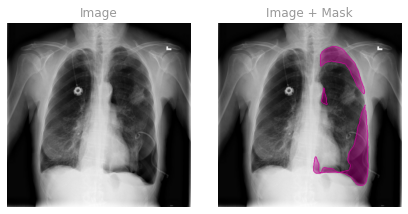



Augmentations



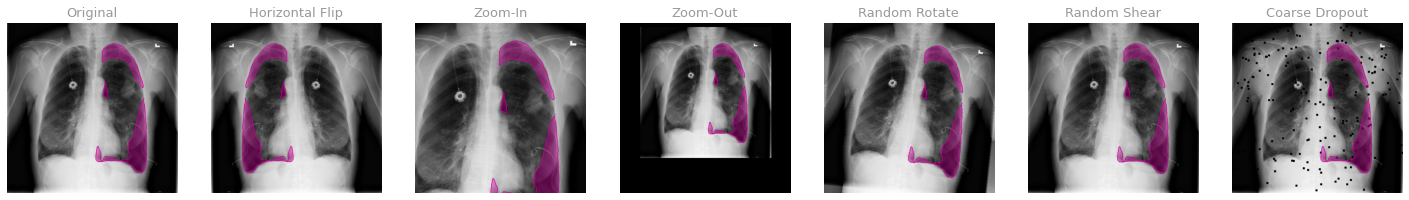

In [ ]:
#@markdown  ← reload to show next example
if num_examples:
    idx = idx + 1 if idx < num_examples-1 else 0
    print('Image and Mask\n')
    plot_image_mask(data_examples[idx], height=3)

    print('\n\nAugmentations\n')
    show_augmentations(*data_examples[idx])

Image and Mask



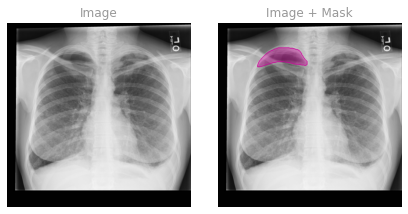



Augmentations



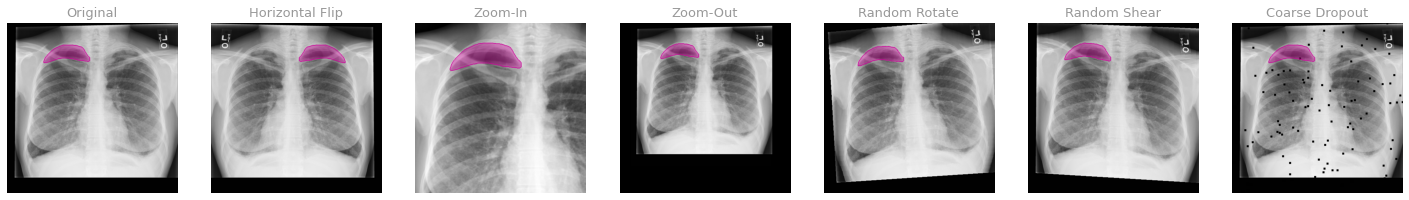

In [ ]:
#@markdown  ← reload to show next example
if num_examples:
    idx = idx + 1 if idx < num_examples-1 else 0
    print('Image and Mask\n')
    plot_image_mask(data_examples[idx], height=3)

    print('\n\nAugmentations\n')
    show_augmentations(*data_examples[idx])

## Logs, Weights Import and Organization

In [ ]:
#@markdown Importing Trained Weights
zip_dest = PROJECT_DIR + 'pneumothorax-fold-1-weights.zip'
if ADD_PRETRAINED: 
    if not os.path.isfile(zip_dest):
        !gdown https://drive.google.com/uc?id=1ptjR8KYSg64CZOvp4vVH3GyTROvjETyk -O {zip_dest}
    !unzip -qn {zip_dest} -d {weights_dir} 

Downloading...
From: https://drive.google.com/uc?id=1ptjR8KYSg64CZOvp4vVH3GyTROvjETyk
To: /content/pneumothorax-fold-1-weights.zip
554MB [00:04, 129MB/s]


In [ ]:
#@markdown Weights Management

# Get names of saved weights (if any) in main weights directory
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

!mkdir -p {weights_dir}discarded

weights_metrics = {}
weights_names = {}
for w in saved_weights:
    prefix, sz, _ , metric = w.split('_')
    prefix = '{}_{}'.format(prefix, sz)
    metric_float = float(metric.split('.')[0])*10e-6
    if not prefix in weights_metrics:
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    elif metric_float > weights_metrics[prefix]:
        !mv {weights_dir}{weights_names[prefix]} {weights_dir}discarded/
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    else: 
        !mv {weights_dir}{w} {weights_dir}discarded/

def check_and_save(history, model, fold_num, img_size, metric, metric_abbr = 'acc',
                   current_wname = 'weights.h5', weights_dir=weights_dir):
    current_metric = max(history.history[metric])
    size_str = str(img_size[0]) + 'x' + str(img_size[1])
    prefix = '{}-f{}_{}'.format(model.name.lower(), fold_num, size_str)
    metric_str = str(current_metric*10e4)[:5]
    weights_name = '{}_{}_{}.h5'.format(prefix, metric_abbr, metric_str)
    if not prefix in weights_metrics or current_metric >= weights_metrics[prefix]: 
        weights_names[prefix] = weights_name
        if prefix in weights_metrics:
            !rm -r {weights_dir}{prefix}*
        !cp {current_wname} {weights_dir}{weights_name}
        weights_metrics[prefix] = current_metric
        saved_weights.append(weights_name)
    return None

def create_df_row(w):
    # w: (str) is the filename of the saved weights
    base, size, _, score = w.split('_')
    key_id = '{}_{}'.format(base, size)
    score = float(score.split('.')[0])*10e-6
    size = eval(size.replace('x', ', '))
    base, efn_ver, model_type, fold_num = base.split('-')
    metric = 'accuracy' if 'bin' in model_type else 'avg image-wise dice'
    if 'bin' in model_type: model_type = 'binary' 
    elif 'pp' in model_type: model_type = 'unet++' 
    else: model_type = 'unet' 
    backbone, fold_num = base+efn_ver, int(fold_num[1])
    return [key_id, backbone, fold_num, size, score, metric, model_type, w]

def get_best_weights(df, n_per_fold = 5, sort_by_col = 'score', 
                     group_by_col = 'fold', mode = 'max'):
    m = df.groupby(group_by_col)[sort_by_col]
    m = m.nlargest(n_per_fold) if mode == 'max' else m.nsmallest(n_per_fold)
    try: idxs = [i[1] for i in m.index]
    except: idxs = [i for i in m.index]
    return df.loc[idxs].reset_index(drop=True)

In [ ]:
#@markdown Existing Weights
col_names = ['key', 'base', 'fold', 'size', 'score', 'metric', 'model_type', 'filename']
bin_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
seg_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 

weights_df = pd.DataFrame(bin_rows + seg_rows, columns = col_names)
display(weights_df[col_names[:7]])

,key,base,fold,size,score,metric,model_type
0,efficientnet-b4-bin-f1_1024x1024,efficientnetb4,1,"(1024, 1024)",0.91708,accuracy,binary
1,efficientnet-b4-bin-f1_512x512,efficientnetb4,1,"(512, 512)",0.91776,accuracy,binary
2,efficientnet-b3-binFT-f1_1024x1024,efficientnetb3,1,"(1024, 1024)",0.92105,accuracy,binary
3,efficientnet-b2-bin-f1_1024x1024,efficientnetb2,1,"(1024, 1024)",0.91873,accuracy,binary
4,efficientnet-b3-unetFT-f1_544x544,efficientnetb3,1,"(544, 544)",0.56986,avg image-wise dice,unet
5,efficientnet-b4-unetpp-f1_480x480,efficientnetb4,1,"(480, 480)",0.55737,avg image-wise dice,unet++
6,efficientnet-b4-unetFT-f1_544x544,efficientnetb4,1,"(544, 544)",0.56634,avg image-wise dice,unet
7,efficientnet-b1-unetpp-f1_512x512,efficientnetb1,1,"(512, 512)",0.56146,avg image-wise dice,unet++


# Training

## Training Binary Classifiers




In [ ]:
EPOCHS = 30
use_unmasked = True
p_undersample = 0.50 # rate to exclude x-rays labeled 0

metric_monitor = performance_monitor('val_accuracy', 'max')
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.25)

lr_params =  [3e-4,  3e-4,  1e-6, 2, 4, 8e-1]
lr_sched = lr_schedule_builder(lr_params)
nadam = tf.keras.optimizers.Nadam() 

Specify the folds, image (side) size and EfficientNet versions to train. 

The loop is set to train squared images, however this is not required, any image size $(H, W)$ can be used as `target_size` . For the segmentation model, this is a bit more restricted as both $H$ and $W$ have to both be divisible by 32 but a 1:1 image ratio is not required.  

For `efficientnet_versions`, any of the B0-B7 versions can be used but adjustments to the batch size (i.e. `imgs_per_replica`) would have to be done for larger EfficientNet classifiers and larger image sizes to avoid OOM errors. 

In [ ]:
folds_to_train = [1] 
dims_to_train = [512] 
efficientnet_versions = [1, 2]

In [ ]:
if TRAINING:
    for training_fold in folds_to_train:
        for dim in dims_to_train: 
            target_size = (dim, dim)
            print(hline)
            cache_val, imgs_per_replica = (True, 8) if dim <= 512 else (False, 4)
            datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica , 
                                'label', use_unmasked, p_undersample, cache_val)
            INPUT_SHAPE  = (*target_size, 3)
            for efn_ver in efficientnet_versions:
                base_model = 'EfficientNet-B{}'.format(efn_ver)
                print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                        base_model, training_fold, target_size) + hline)
                
                with strategy.scope():                       
                    model = build_classifier(base_model, N_CLASSES, INPUT_SHAPE, 
                                                name_suffix='-bin')
                    model.compile(optimizer=nadam, loss=loss, metrics=['accuracy', 'AUC']) 

                checkpoint = config_checkpoint(monitor ='val_accuracy', mode = 'max')
                train_begin = time()

                history = model.fit(datasets['train'], steps_per_epoch=steps['train'],
                        epochs = EPOCHS,
                        verbose = 0, 
                        callbacks=[lr_sched, metric_monitor, checkpoint],
                        validation_data = datasets['valid'])
                
                check_and_save(history, model, training_fold, target_size, 'val_accuracy')
                print('Time to train {} epochs: {} (mm:ss)\n'.format(
                    EPOCHS, time_passed(train_begin)))
                
                del model
                K.clear_session()

    del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((64, 512, 512, 3), (64,)), types: (tf.float32, tf.int32)
Steps per epoch:  92
Num train examples 5884 approx
Num valid examples 2412
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B1 on FOLD 1 with image size (512, 512)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_accuracy improved from -inf to 0.8408
New best at Epoch 002 val_accuracy improved from 0.8408 to 0.8578
New best at Epoch 003 val_accuracy improved from 0.8578 to 0.8864
New best at Epoch 004 val_accuracy improved from 0.8864 to 0.8959
New best at Epoch 005 val_accuracy improved from 0.8959 to 0.8964
New best at Epoch 006 val_accuracy improved from 0.8964 to 0.8976
New best at Epoch 011 val_accuracy improved from 0.8976 to 0.9071
New best at Epoch 015 val_accuracy improved from 0.9071 to 0.9088
Ne

## Training Segmentation Components


In [ ]:
EPOCHS = 30
imgs_per_replica = 4
metric_monitor = performance_monitor('val_dice_coef', 'max')

lr_params =  [3e-4,  3e-3,  1e-6, 3, 4, 8e-1] 
lr_sched = lr_schedule_builder(lr_params)

if TRAINING:  
    !pip -q install tensorflow_addons >/dev/null
    import tensorflow_addons as tfa
    radam = tfa.optimizers.RectifiedAdam()

The following loop will train U-Net and UNet++ (i.e `xnet`) networks.

The loop is set to train squared images, however this is not required, any image size $(H, W)$ can be used as `target_size`  as long as both $H$ and $W$ are divisible by 32. 

For `efficientnet_versions`, any of the B0-B7 versions can be used as encoders for the U-Net and UNet++ networks, however, I did not test training on networks with encoders larger than EfficientNetB5. Adjustments to the batch size would have to be done for larger EfficientNet encoders and larger image sizes to avoid OOM errors.

In [ ]:
folds_to_train = [1] 
dims_to_train = [480] 
efficientnet_versions = [3]
seg_models = [unet, xnet]

In [ ]:
if TRAINING:
    for training_fold in folds_to_train:
        for dim in dims_to_train: 
            target_size = (dim, dim)
            print(hline)
            datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 
                                        cache_val = False)
            INPUT_SHAPE  = (*target_size, 3)
            for seg_model in seg_models:
                for efn_ver in efficientnet_versions:
                    backbone_name = 'EfficientNet-B{}'.format(efn_ver)
                    with strategy.scope():
                        model = seg_model(backbone_name, N_CLASSES, INPUT_SHAPE)
                        model.compile(optimizer=radam, loss=bce_dice_loss, 
                                    metrics=[dice_coef, dice_avg]) 

                    print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                                        model.name, training_fold, target_size) + hline)

                    checkpoint = config_checkpoint(monitor ='val_dice_avg', mode = 'max')
                    train_begin = time()
                    history = model.fit(datasets['train'], steps_per_epoch=steps['train'], 
                                    epochs = EPOCHS,
                                    verbose = 0, 
                                    callbacks=[lr_sched, metric_monitor, checkpoint],
                                    validation_data=datasets['valid'])

                    check_and_save(history, model, training_fold, target_size, 'val_dice_avg', 'adice')
                    print('Time to train {} epochs: {} (mm:ss)\n'.format(
                        EPOCHS, time_passed(train_begin)))
                    del model
                    K.clear_session()

    del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((32, 480, 480, 3), (32, 480, 480, 1)), types: (tf.float32, tf.float32)
Steps per epoch:  67
Num train examples 2133 
Num valid examples 536
───────────────────────────────────────────────────────────────────────────────────
Training Efficientnet-B3-Unet on FOLD 1 with image size (480, 480)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_dice_coef improved from -inf to 0.0263
New best at Epoch 002 val_dice_coef improved from 0.0263 to 0.0795
New best at Epoch 004 val_dice_coef improved from 0.0795 to 0.1693
New best at Epoch 005 val_dice_coef improved from 0.1693 to 0.3392
New best at Epoch 006 val_dice_coef improved from 0.3392 to 0.3898
New best at Epoch 007 val_dice_coef improved from 0.3898 to 0.4562
New best at Epoch 009 val_dice_coef improved from 0.4562 to 0.5635
New best at Epoch 010 val_dice_coef improved from

# Evaluation

In [ ]:
#@markdown Load Trained Model, Assemble Ensemble Functions
!mkdir -p ./weights 

def load_pretrained_model(weights_id, compile_model = True, opt = [], 
                          loss = 'default', metrics = 'default', details = []):
    
    prefix, size = weights_id.split('_')
    size = eval(size.replace('x', ', '))
    base, base_ver, model_type, _  = prefix.split('-')
    wname = weights_names[weights_id]
    weights_path = weights_dir + wname
    
    # Import weights to colab (if elsewhere) to avoid "bad symbol" errors
    if not os.path.isfile('./weights/' + wname):
        !cp {weights_path} ./weights/{wname}
    weights_path = './weights/' + wname

    base_name = base + base_ver

    if 'bin' in model_type: builder = build_classifier
    elif 'unetpp' in model_type: builder = xnet
    elif 'unet' in model_type: builder = unet

    if compile_model:
        if 'bin' in model_type:
            if metrics == 'default': metrics = ['accuracy', 'AUC']
            if loss == 'default': loss = 'binary_crossentropy'
        elif 'unet' in model_type:
            if metrics == 'default': metrics = [dice_coef, dice_avg]
            if loss == 'default': loss = [bce_dice_loss]
        
    with strategy.scope():
        model = builder(base_name, 1, input_shape=(*size, 3), weights = None)
        model.load_weights(weights_path)
        if compile_model:
            model.compile(optimizer=opt, loss=loss, metrics=metrics)
            
    if len(details) > 0: 
        scope = locals()
        return (model, *[eval(d, scope) for d in details])
    else: return model

def determine_outter_size(weights_keys):
    sizes = [eval(k.split('_')[-1].replace('x', ', ')) for k in weights_keys]
    areas = [s[0]*s[1] for s in sizes]
    return sizes[np.argmax(areas)]

def assemble_ensemble(weights_ids, outter_size = 'auto', ensemble_type = 'auto', 
                      metrics = 'default', loss = 'default', details = []):
    if outter_size == 'auto': outter_size = determine_outter_size(weights_ids)
    if ensemble_type == 'auto': 
        ensemble_type = 'segmentation' if 'unet' in weights_ids[0] else 'binary'

    ensemble_outputs = []
    resized_inputs = {}
    with strategy.scope():
        x = L.Input(shape=(*outter_size, 3))
        for i, w in enumerate(weights_ids):
            model, size = load_pretrained_model(w, compile_model = False, details = ['size'])
            model._name = '{}-M{}'.format(model.name, i)
            if size == outter_size:
                model_output = model(x)
            else:
                if not str(size) in resized_inputs: 
                    resized_inputs[str(size)] = tf.image.resize(x, size)
                model_output = model(resized_inputs[str(size)])
                if ensemble_type == 'segmentation':
                    model_output = tf.image.resize(model_output, outter_size)

            ensemble_outputs.append(model_output)

        y = L.Average(name = 'Simple_Average')(ensemble_outputs)

        if metrics == 'default':
            if ensemble_type == 'segmentation': metrics = [dice_coef, dice_avg] 
            else: metrics = ['accuracy', 'AUC']

        if loss == 'default':
            if ensemble_type == 'segmentation': loss = [bce_dice_loss]
            else: loss = 'binary_crossentropy'

        name = '{}_Ensemble'.format(ensemble_type.title())
        ensemble = tf.keras.Model(inputs=x, outputs=y, name=name)
        ensemble.compile(optimizer=[], loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (ensemble, *[eval(d, scope) for d in details])
    else: return ensemble

eval_temp_fix = lambda model, ds: model.evaluate(ds, steps = 1, verbose = 0)[3:]
# current TF version has a documented issue in which the first evaluation after 
# using model.load_weights() is not accurate. This "fix" circumvents the issue.

In [ ]:
#@markdown Evaluation Datasets
def data_meta(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, vars = ('img_id', 'label', 'rle')), 
                          num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

def get_eval_datasets(fold_num, target_size = (256, 256), target_var = 'mask', 
                      imgs_per_replica = 8, augment = False, repeat = False):
    '''
    Returns Datasets for evaluation, they are ordered, do not drop remainder. 
    Augmentations and Repeat if requested. 
    '''
    batch_size = imgs_per_replica * N_REPLICAS
    tfrec_lists = get_fold_file_lists(fold_num, use_unmasked = True)
    create_ds = lambda fnames: get_dataset(fnames, target_size, batch_size, target_var, 
                                           augment = augment, repeat = repeat, ordered = True)
    keys = 'train', 'valid'
    datasets = {k: create_ds(tfrec_lists[i]) for i, k in enumerate(keys)}
    counts = {k: count_data_items(tfrec_lists[i]) for i, k in enumerate(keys)}
    min_steps = {k: np.ceil(counts[k]/batch_size).astype(int) for k in counts }
    meta_datasets = {k: data_meta(tfrec_lists[i]) for i, k in enumerate(keys)}
    return datasets, counts, min_steps, meta_datasets

## Binary Evaluation
The following evaluation selects from the weights trained above plus any other weights saved in the `weights_dir` directory, including those imported by `ADD_PRETRAINED = True`. 

The following evaluation corresponds to the fold 1 partition of the data. To perform evaluation corresponding to any of the other folds (if already trained), specify the `fold_num` variable. 


In [ ]:
fold_num = 1
_, counts, steps, meta_dsets = get_eval_datasets(fold_num)

In [ ]:
#@markdown Build Metadata from TFRecs (Image IDs, Labels, RLEs)
start_retrive_meta = time()
meta_list = []
for item in meta_dsets['valid']:
    meta_list.append([i.numpy() for i in item])

meta_df = pd.DataFrame(meta_list, columns = ['ImageId', 'label', 'rle'])
del meta_list
print('Time to build metadata from tfrecs: {}'.format(time_passed(start_retrive_meta)))

Time to build metadata from tfrecs: 00:15


In [ ]:
#@markdown Selected Binary Classifiers for Ensemble
bin_df_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
bin_df = pd.DataFrame(bin_df_rows, columns = col_names)

binary_ensemble_size = 4
best_bin = get_best_weights(bin_df, binary_ensemble_size)

best_bin_fold = best_bin[best_bin.fold==fold_num]
bin_keys = best_bin_fold.key.values

display(best_bin_fold[col_names[1:7]])

,base,fold,size,score,metric,model_type
0,efficientnetb3,1,"(1024, 1024)",0.92105,accuracy,binary
1,efficientnetb2,1,"(1024, 1024)",0.91873,accuracy,binary
2,efficientnetb4,1,"(512, 512)",0.91776,accuracy,binary
3,efficientnetb4,1,"(1024, 1024)",0.91708,accuracy,binary


Evaluation using `model.evaluate()`. Using repeated dataset with specified steps so that results can be compared between augmented and not augmented data. 

Evaluate single best classifier

In [ ]:
model, size = load_pretrained_model(bin_keys[0], details = ['size'])
dsets_repeat = get_eval_datasets(fold_num, size, 'label', repeat = True)[0]
dsets_aug = get_eval_datasets(fold_num, size, 'label', repeat = True, augment = True)[0]
eval_temp_fix(model, dsets_repeat['valid'])

print('\nEvaluating on un-augmented validation data')
_ = model.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on un-augmented train data')
_ = model.evaluate(dsets_repeat['train'], steps = steps['train'])

del model; 
K.clear_session()


Evaluating on un-augmented validation data
38/38 [==============================] - 19s 463ms/step - loss: 0.2731 - accuracy: 0.9206 - auc: 0.9514

Evaluating on un-augmented train data
151/151 [==============================] - 76s 491ms/step - loss: 0.1699 - accuracy: 0.9831 - auc: 0.9980


Evaluate ensemble

In [ ]:
binary_ensemble, outter_size = assemble_ensemble(bin_keys, details = ['outter_size'])
if outter_size != size:
    dsets_repeat = get_eval_datasets(fold_num, outter_size, 'label', repeat = True)[0]
    dsets_aug = get_eval_datasets(fold_num, outter_size, 'label', repeat = True, augment = True)[0]

eval_temp_fix(binary_ensemble, dsets_repeat['valid'])
binary_ensemble.summary()

Model: "Binary_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B3-M0 (Functional) (None, 1)            10785065    input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B2-M1 (Functional) (None, 1)            7769971     input_1[0][0]                    
____________________________________________________________________________________

In [ ]:
n_TTA = 5 # number of test time augmentations
print('\nEvaluating on un-augmented validation data')
_ = binary_ensemble.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on augmented validation data')
_ = binary_ensemble.evaluate(dsets_aug['valid'], steps = steps['valid']*n_TTA)


Evaluating on un-augmented validation data
38/38 [==============================] - 39s 993ms/step - loss: 0.2596 - accuracy: 0.9239 - auc: 0.9664

Evaluating on augmented validation data
190/190 [==============================] - 269s 1s/step - loss: 0.2540 - accuracy: 0.9297 - auc: 0.9683


During testing it was observed that the ensemble model consistently outperformed the single best performing classifier; it typically increased accuracy by about 0.3 percent and AUC by about 1.3 percent. 

Random test-time augmentations generally improved accuracy by about 0.4 percent on the ensemble model. 

Predict using test time augmentations on binary ensemble

In [ ]:
batch_size = [len(i[0]) for i in dsets_aug['valid'].take(1)][0] 
n_preds_needed = n_TTA*counts['valid']
tta_steps = np.ceil(n_preds_needed/batch_size).astype(int)

preds = binary_ensemble.predict(dsets_aug['valid'], steps = tta_steps, verbose=1)
preds = preds[:n_preds_needed,]
preds = preds.reshape((counts['valid'], n_TTA), order='F')
preds_prob = np.mean(preds, axis = 1)
meta_df['preds_prob'] = preds_prob
del binary_ensemble

189/189 [==============================] - 296s 2s/step


### Binary Classification Performance Reports


In [ ]:
cm_html_str = lambda cm, subtitle: confusion_matrix_html(
    cm, classes, False, subtitle, max_rgb=(179, 0, 89), contrast=.9)

targets, preds_prob = meta_df.label.values, meta_df.preds_prob.values

<h3> Evaluation on full validation data </h3> 

In [ ]:
_, cm, metrics_strings = performance_metrics(targets, preds_prob, report_type = 'total')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(Full Validation Data)')
display(HTML(html_report_base % (cm_string, table_string)))

<h3>  Evaluation for Higher Confidence Predictions </h3> 

This section experiments by assigning high confidence thresholds for the labeling of the x-rays. Probabilites below or above the thresholds are assigned a prediction ("no disease", "disease", respectively). Probabilities within the 2 thresholds are labeled as inconclusive. 

The biggest weakness for the model is in its sensitivity, which would most likely be its most crucial objective since missing the presence of the disease would be the most dangerous. 

During post-prediction analysis, it was noted that for positive cases the confidence at detecting the disease was positively correlated with the area indicating the disease in the image. So long as such area would be of medical significance (i.e. larger area, more medical urgency), the model would be better at detecting the most urgent cases of the disease. This could potentially assist at the prioritization of cases when medical resources are scarce. 


In [ ]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.18 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(High Confidence Thresholds)')
display(HTML(html_report_base % (cm_string, table_string)))

In [ ]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.175 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(High Confidence Thresholds)')
display(HTML(html_report_base % (cm_string, table_string)))

## Mask Predictions Evaluation

The evaluation below corresponds to the same fold used in the Binary Evaluation. The data created in that step is needed for evaluating the mask predictions below. Metadata and binary prediction data from the `meta_df` dataframe is needed in the mask prediction evaluation loop. 

In [ ]:
#@markdown Segmentation Ensemble Components Info

seg_df_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 
seg_df = pd.DataFrame(seg_df_rows, columns = col_names)

n_top = 4
best_seg = get_best_weights(seg_df, n_top)
best_seg_fold = best_seg[best_seg.fold==fold_num]
seg_keys = best_seg_fold.key.values
display(best_seg_fold[col_names[1:7]])

,base,fold,size,score,metric,model_type
0,efficientnetb3,1,"(544, 544)",0.56986,avg image-wise dice,unet
1,efficientnetb4,1,"(544, 544)",0.56634,avg image-wise dice,unet
2,efficientnetb1,1,"(512, 512)",0.56146,avg image-wise dice,unet++
3,efficientnetb4,1,"(480, 480)",0.55737,avg image-wise dice,unet++


Build Mask Segmentation Ensemble and Split Dataset

Dataset splitting is required since post-processing takes place using CPU. Although the TPU is able to make all predictions at once, storing all predictions to make them available for the CPU will exhaust resources. Splitting the dataset in `n_parts` allows to use the TPU to produce manegeable sized prediction arrays for CPU post-processing. 

In [ ]:
segmentation_ensemble, outter_size = assemble_ensemble(seg_keys, details = ['outter_size'])

n_parts = 3
dsets, counts, steps, _ = get_eval_datasets(fold_num, outter_size, 'mask')
valid_ds_parts = split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)
segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 544, 544, 3) 0                                            
__________________________________________________________________________________________________
tf.image.resize_1 (TFOpLambda)  (None, 512, 512, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.image.resize_3 (TFOpLambda)  (None, 480, 480, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B1-UnetPP-M2 (Func (None, 512, 512, 1)  16013857    tf.image.resize_1[0][0]          
______________________________________________________________________________

<h3>  Mask Prediction Evaluation on Full Validation Dataset </h3> 

The following will calculate the image-wise average dice coefficient over the entire out-of-fold data corresponding the `fold_num` specified above. Unlike the dice coefficient calculated during training, which only included images labeled with "disease", this calculation includes both types of x-rays. Thus, this calculation produces the metric which is more relevant to the official challenge. 

In [ ]:
meta_dict = meta_df.to_dict()
dice_eval = lambda y, p: dice_coef(tf.cast(y, tf.float32), tf.cast(p, tf.float32))
empty_mask = np.zeros(outter_size, int) 
n_demo =  100 # save some predictions for demo

**Post-Processing Parameters**

Post-processing is done by: 
1. Using the binary predictions to determine if the x-ray presnts the disease. X-rays with probability below `binary_threshold` will be assigned an empty mask. 
2. Gathering high confidence mask predictions as determined by `thresh_upper`, making sure the high confidence area meets the minimum area requirements. X-rays with a high confidence area below `min_area` will be assigned an empty mask. 
3. Once the image "passed" the probability and area "tests" above, all mask predictions with probabilities above a low threshold, as indicated by `thresh_lower`, will be determined to be part of a detected disease mask.

In [ ]:
binary_treshhold = 0.60
thresh_upper = 0.75
thresh_lower = 0.40
min_area = 200 

In [ ]:
demo_preds = [] 
dices = []
i = 0
start_preds = time()
for p, ds_part in enumerate(valid_ds_parts): 
    print('Predicting and processing part {} of {}'.format(p+1, n_parts))
    preds = segmentation_ensemble.predict(ds_part, verbose = 1)
    preds = np.squeeze(preds)
    gt_masks = [m.numpy().squeeze() for m in ds_part.map(lambda x, y: y).unbatch()]
    print('Shape of predictions part {}: {}\n'.format(p+1, preds.shape))
    for gt_mask, pred in zip(gt_masks, preds):
        instance_id = meta_dict['ImageId'][i]
        if meta_dict['preds_prob'][i]  > binary_treshhold:
            pred_ = pred.copy()
            pred  = (pred > thresh_upper).astype(int)
            if pred.sum() < min_area: pred_mask = empty_mask
            else: 
                pred_mask = (pred_ > thresh_lower).astype(int)
                if len(demo_preds) < n_demo:
                    demo_preds.append([i, gt_mask, pred_mask])
        else: pred_mask = empty_mask
        dices.append(dice_eval(gt_mask, pred_mask).numpy())
        i += 1
    del preds, gt_masks

print('Elapsed time {}'.format(time_passed(start_preds)))
print('Mean Dice:', np.mean(dices))

Predicting and processing part 1 of 3
13/13 [==============================] - 89s 2s/step
Shape of predictions part 1: (832, 544, 544)

Predicting and processing part 2 of 3
13/13 [==============================] - 26s 2s/step
Shape of predictions part 2: (832, 544, 544)

Predicting and processing part 3 of 3
12/12 [==============================] - 24s 2s/step
Shape of predictions part 3: (748, 544, 544)

Elapsed time 04:05
Mean Dice: 0.8712019


## Mask Prediction Examples

In [ ]:
#@markdown Plot Mask Ground Truth vs. Prediction
def plot_mask_gt_vs_prediction(pred_demo):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    rgb_colors = {'Ground Truth': (200, 0, 150),
                  'Prediction':   (0, 51, 204)}

    for c, (key, rgb_color) in enumerate(rgb_colors.items()):
        ax = fig.axes[c]
        ax.imshow(pred_demo[0], cmap=plt.cm.bone)
        ax.imshow(contoured_mask(pred_demo[c+1], rgb_color = rgb_color, alpha = 0.2))
        ax.axis('off')
        ax.set_title(key, fontdict={'fontsize': 13})
    plt.show()
    return None

In [ ]:
#@markdown Retrieve Images for Demo
ds_part_0 = valid_ds_parts[0].map(lambda x, y: x).unbatch()
masked_idxs = [p[0] for p in demo_preds]
imgs = []
for i, img in enumerate(ds_part_0):
    if i in masked_idxs: 
        imgs.append(img)
        if len(imgs) == n_demo: break

demo_tuples = [(imgs[i], d[1], d[2]) for i, d in enumerate(demo_preds)]

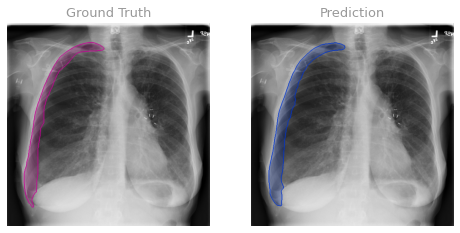

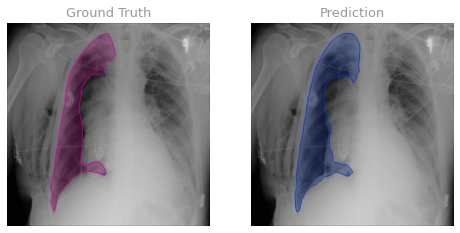

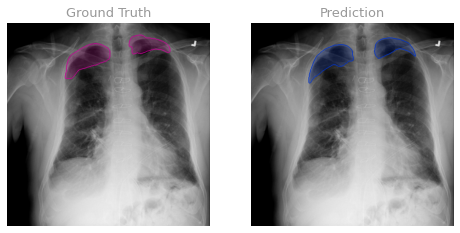

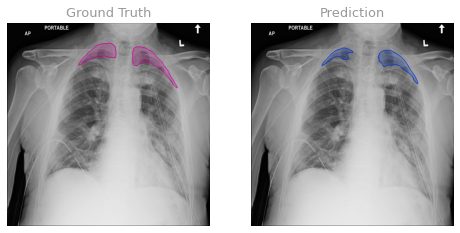

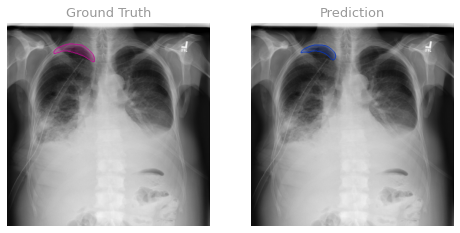

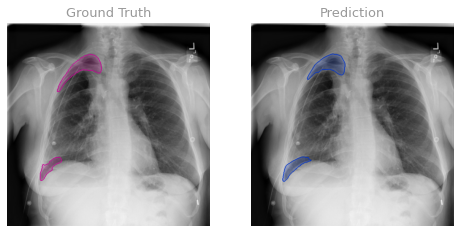

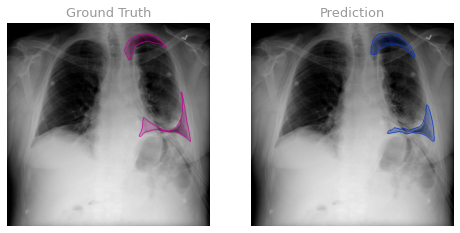

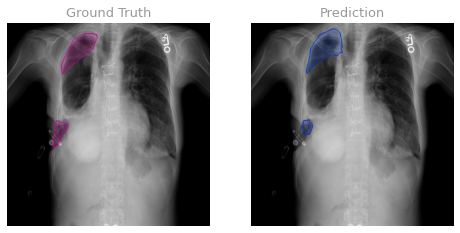

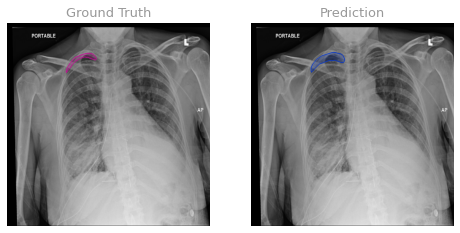

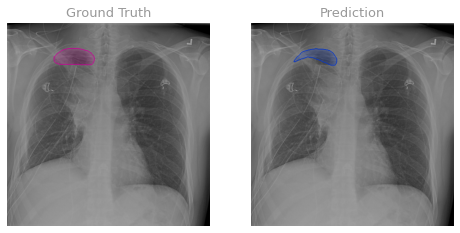

In [ ]:
#@markdown Mask Prediciton Examples
for i in np.random.choice(n_demo, 10, replace=False):
    plot_mask_gt_vs_prediction(demo_tuples[i])
    print('\n')

In [ ]:
#@markdown Runtime
print('Time to run notebook: ', time_passed(start_notebook))
print('Notebook finished at:', current_time_str())

Time to run notebook:  01:34:20
Notebook finished at: 11:54 AM


# References:

- Ronneberger O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. [arXiv:1505.04597v1](https://arxiv.org/abs/1505.04597v1).

- Tan, M., & Le, Q. V. (2020). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. [arXiv:1905.11946v5](https://arxiv.org/abs/1905.11946v5).

- Zhou, Z., Siddiquee, M., Tajbakhsh, N., & Liang, J. (2019). UNet++: Redesigning Skip Connections to Exploit Multiscale Features in Image Segmentation. [arXiv:1912.05074v2](https://arxiv.org/abs/1912.05074v2).